In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cobra.flux_analysis import flux_variability_analysis as fva
from cobra.flux_analysis import pfba
from gsmmutils import MyModel
import seaborn as sns
sns.set(rc={'figure.figsize':(35,8.27)})
DATA_PATH = r"C:\Users\Bisbii\PythonProjects\GSMMutils\data"
from os.path import join

In [2]:
# ds = MyModel(join(DATA_PATH, 'models/model_ds.xml'), 'e_Biomass__cytop')
# ds.set_prism_reaction("PRISM_white_LED__extr")
# print(ds.slim_optimize())
# ng = MyModel(join(DATA_PATH, 'models/model_ng.xml'), 'e_Biomass__cytop')
# ng.set_prism_reaction("PRISM_solar_litho__extr")
# print(ng.slim_optimize())
pl = MyModel(join(DATA_PATH, 'models/model_pl.xml'), 'e_Biomass__cytop')
pl.set_prism_reaction("PRISM_fluorescent_warm_18W__extr")
print(pl.slim_optimize())

Loading

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-15
Reactions: 4740
Metabolites: 4182
Genes: 1353
Model loaded
0.22888006635190092


In [4]:
def get_ps_params(model):
    sol = pfba(model)
    photons_absorbed = sum(sol.fluxes[r.id] for r in model.reactions if r.id.startswith("PHOA"))
    print(sol['R00024__chlo']/photons_absorbed)
    print(sol['EX_C00011__dra']/photons_absorbed)
    print(abs(sol['EX_C00007__dra']/sol['EX_C00011__dra']))
    print(sol["PSII__lum"]/sol['R00024__chlo'])
    print(sol["PSII__lum"]/sol['EX_C00011__dra'])

In [4]:
get_ps_params(ds)

0.05681211862834876
-0.05494096542352939
1.243200037474735
1.816306875158999
-1.8781657887072074


In [5]:
get_ps_params(ng)

0.04412346116737096
-0.03546749375377472
1.408841250800092
1.631668975875118
-2.0298835659163954


In [5]:
get_ps_params(pl)

0.03793853470630891
-0.03495094775856465
1.4161005091197083
1.665537645523557
-1.8079068472149058


In [7]:
results = {}
for light_reaction in light_sources:
    with model as temp_model:
        temp_model.reactions.e_Biomass__cytop.bounds = (0.15, 0.15)
        temp_model.objective = "EX_C00205__dra"
        temp_model.reactions.get_by_id(light_reaction).bounds = (0, 10000)
        for other_reaction in light_sources:
            if other_reaction != light_reaction:
                temp_model.reactions.get_by_id(other_reaction).bounds = (0, 0)
        sol = temp_model.slim_optimize()
        results[light_reaction] = -sol

Text(0, 0.5, 'Light uptake (mmol gDW^-1 d^-1)')

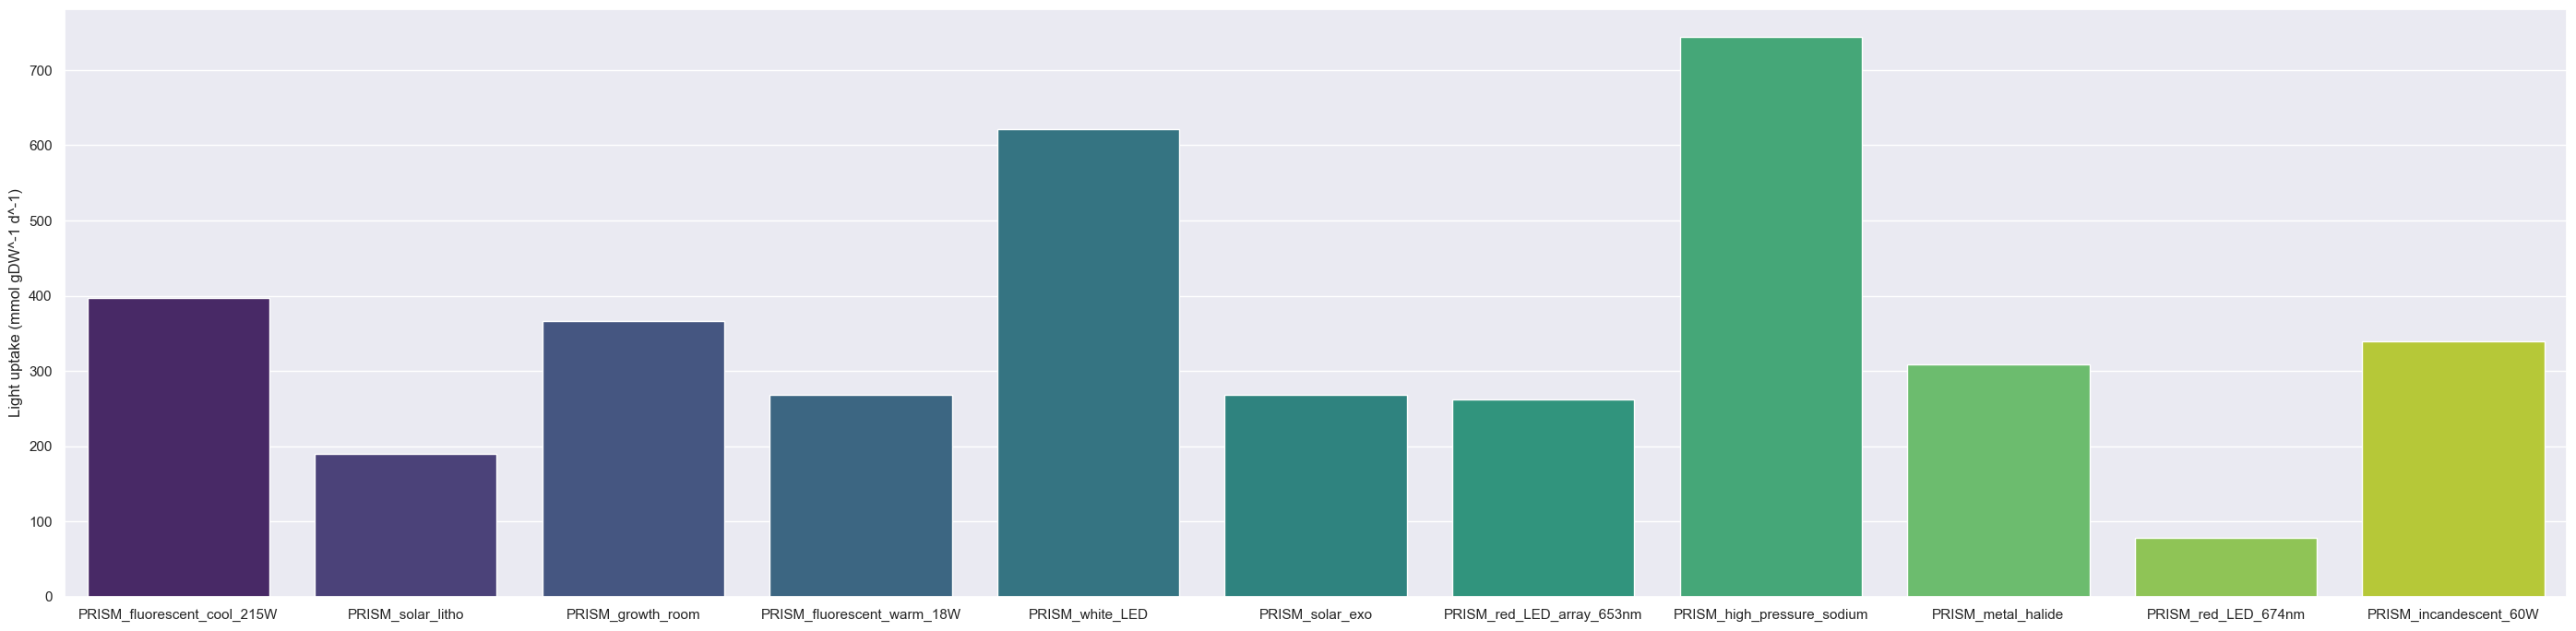

In [9]:
sns.barplot(x=list(key.split("__")[0] for key in results.keys()), y=list(results.values()), hue=list(key.split("__")[0] for key in results.keys()), palette="viridis")
plt.ylabel('Light uptake (mmol gDW^-1 d^-1)')

In [53]:
from cobra.flux_analysis import pfba
def run_simulation(model_copy, i):
    model_copy.exchanges.EX_C00011__dra.bounds = (-8.21, -8.21)
    res, res_o2, pq, res_flv, fva_sols, pfba_sol, pq_pfba  = 0, 0, 0, (0,0), [], 0, 0
    model_copy.exchanges.EX_C00205__dra.bounds = (-i,-i)
    sol = model.optimize()
    if sol != 0 and sol.status == 'optimal':
        try:
            pfba_sol = pfba(model_copy)
            pq_pfba = (pfba_sol["R09503_hn438__lum"]+pfba_sol["R09503_hn673__lum"])/pfba_sol['R00024__chlo']
            pfba_sol = pfba_sol['e_Biomass__cytop']
        except:
            pass
        res = sol['e_Biomass__cytop']
        res_o2 = sol["R09503_hn438__lum"]+sol["R09503_hn673__lum"]
        res_flv = sol['FLV__chlo']
        pq = (sol["R09503_hn438__lum"]+sol["R09503_hn673__lum"])/sol['R00024__chlo']
    return res, res_o2, pq, res_flv, fva_sols, pfba_sol, pq_pfba, i

In [83]:
from joblib import delayed, Parallel
with model:
    light_range = np.arange(0, convert_light_uptake(1000), 200)
    result= Parallel(n_jobs=6)(delayed(run_simulation)(model, e) for e in light_range)
    res = [e[0] for e in result]
    res_o2 = [e[1] for e in result]
    pq = [e[2] for e in result]
    res_flv = [e[3] for e in result]
    fva_sols = [e[4] for e in result]
    pfba_sol = [e[5] for e in result]
    pq_pfba = [e[6] for e in result]

Text(0, 0.5, 'O2/CO2 (mmol gDW^-1 d^-1)')

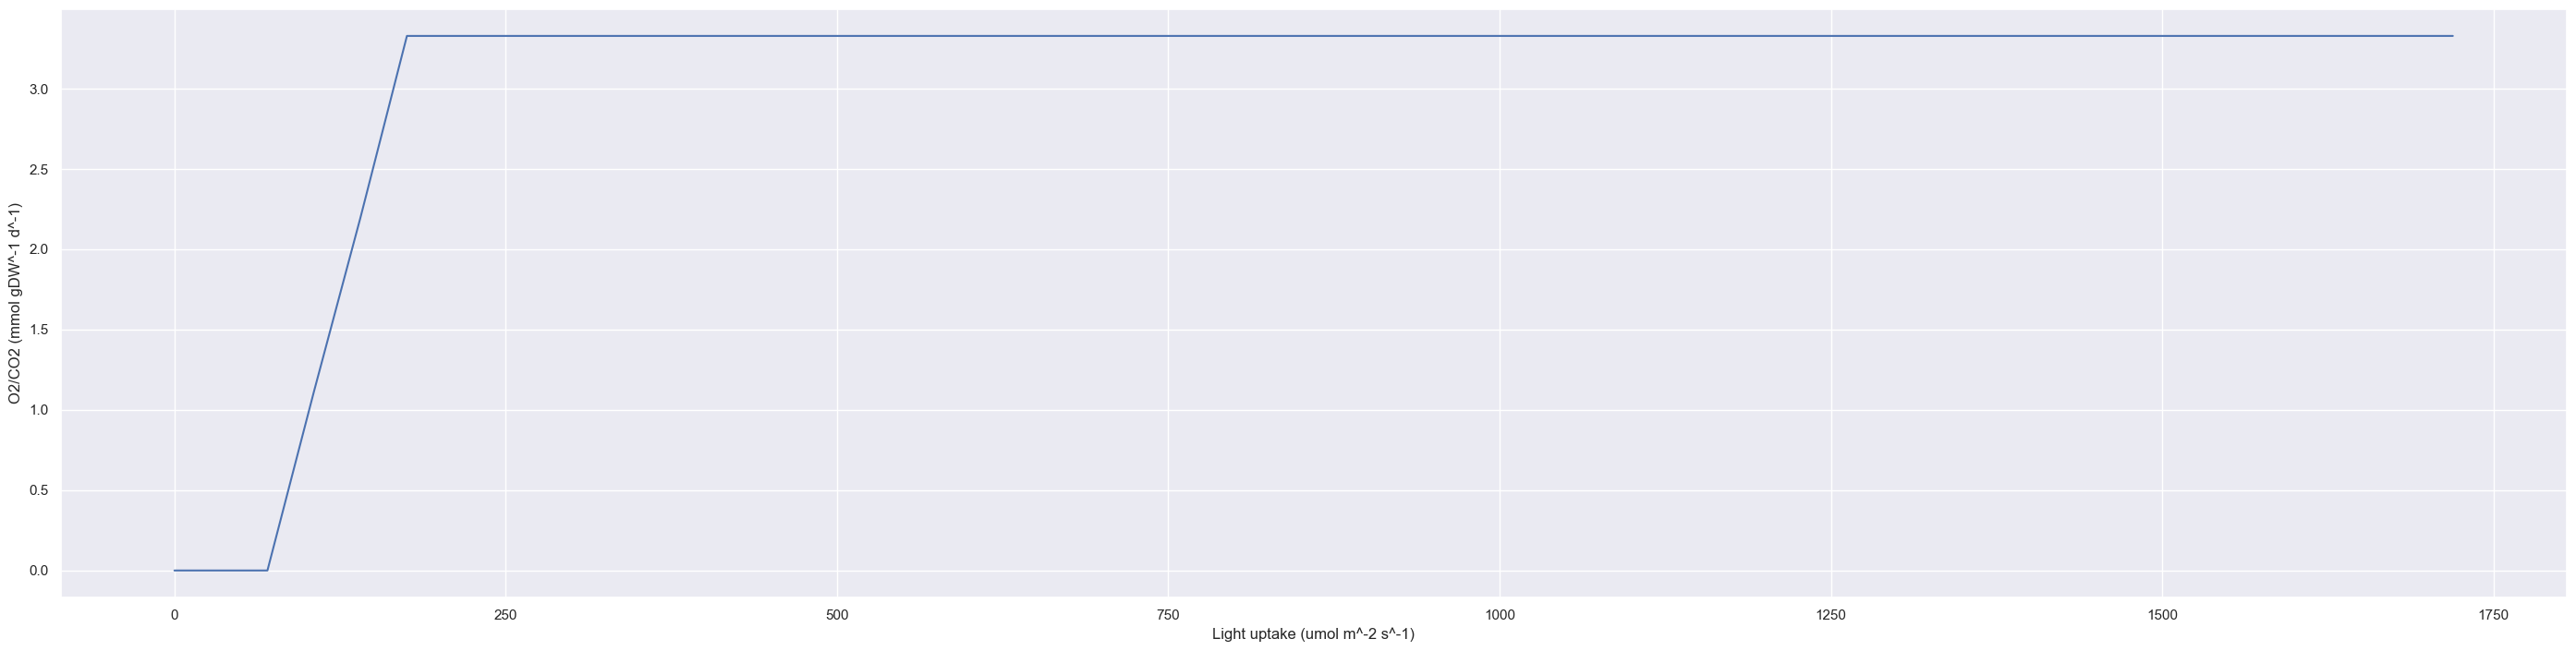

In [85]:
sns.lineplot(x=[convert_light_uptake_rev(e) for e in light_range], y=pq_pfba)
plt.xlabel('Light uptake (umol m^-2 s^-1)')
plt.ylabel('O2/CO2 (mmol gDW^-1 d^-1)')

Text(0, 0.5, 'O2 production (mmol gDW^-1 d^-1)')

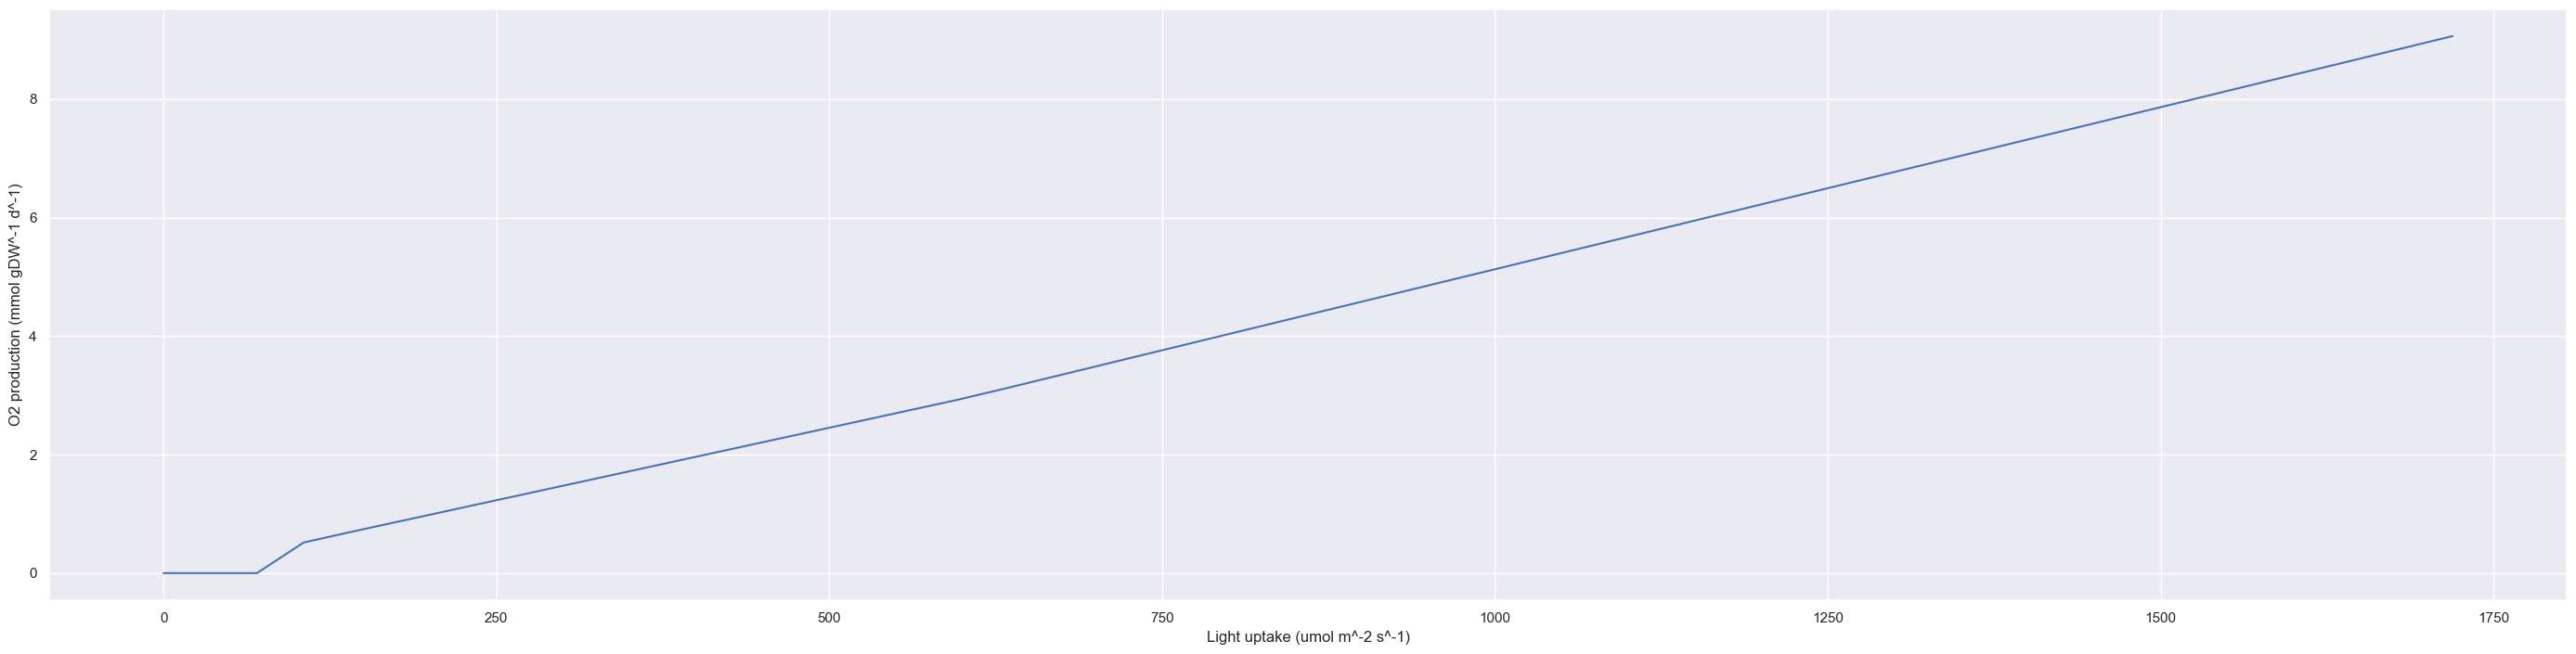

In [86]:
sns.lineplot(x=[convert_light_uptake_rev(e) for e in light_range], y=[e/24 for e in res_o2])
plt.xlabel('Light uptake (umol m^-2 s^-1)')
plt.ylabel('O2 production (mmol gDW^-1 d^-1)')

In [ ]:
npq = []
import seaborn as sns
from tqdm import tqdm
from cobra.flux_analysis import pfba
uptake =  range(50, 3500, 100)
coeff = sum(e for e in ds.reactions.PRISM_white_LED__extr.metabolites.values() if e > 0)
for i in tqdm(uptake):
    ds.exchanges.EX_C00205__dra.bounds = (-i, -i)
    sol = pfba(ds).fluxes
    heat = abs(sol['DM_pho_loss__chlo'])
    ros = abs(sol['T_SOXtu__chlomem'])
    npq.append( (heat + ros) /(abs(sol['EX_C00205__dra'])*coeff))
sns.lineplot(x=uptake, y=npq)

In [ ]:
@deprecated reason="Does not belong here"
atpm_range = np.arange(0, 2, 0.05)
ng.reactions.NGAM__lum.bounds = (0.34, 0.34)
qy = {}
for i in atpm_range:
    ng.reactions.ATPm__cytop.bounds = (i, i)
    sol = pfba(ng)
    photons_absorbed = sum(sol.fluxes[r.id] for r in ng.reactions if r.id.startswith("PHOA"))
    qy[i] = sol.fluxes['R00024__chlo'] / photons_absorbed
# regression, for qy = 0.05
from scipy.optimize import curve_fit
def func(x, a, b):
    return a*x + b
popt, pcov = curve_fit(func, list(qy.keys()), list(qy.values()))
print(popt)
print((0.05 - popt[1]) / popt[0])